In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
DATASET_DIR = '../data/raw/BrainTumor'
TRAIN_DIR = os.path.join(DATASET_DIR, 'Training')
TEST_DIR = os.path.join(DATASET_DIR, 'Testing')

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4 

LEARNING_RATE = 1e-4

if not os.path.exists(TRAIN_DIR) or not os.path.exists(TEST_DIR):
    print("ERROR: 'Training' or 'Testing' folders not found in the specified paths.")
    print(f"Please check the path: {DATASET_DIR}")
else:
    print("Dataset accessed successfully. Starting training...")

Dataset accessed successfully. Starting training...


In [4]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.


In [5]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("\nData loaders are ready.")
print("Classes:", train_generator.class_indices)

Found 1311 images belonging to 4 classes.

Data loaders are ready.
Classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [6]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']   
)

print("Stage 1 Model Ready (Base Model Frozen)")

Stage 1 Model Ready (Base Model Frozen)


In [7]:
EPOCHS_PHASE_1 = 5

print(f"\n*** STARTING TRAINING (Stage 1 - {EPOCHS_PHASE_1} Epoch) ***")

history_1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE_1,
    validation_data=test_generator,
)


*** STARTING TRAINING (Stage 1 - 5 Epoch) ***
Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.7561 - loss: 1.0721 - val_accuracy: 0.8452 - val_loss: 0.4130
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 483s 3s/step - accuracy: 0.8267 - loss: 0.4711 - val_accuracy: 0.8711 - val_loss: 0.3136
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.8403 - loss: 0.4472 - val_accuracy: 0.8680 - val_loss: 0.3292
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.8452 - loss: 0.3945 - val_accuracy: 0.8833 - val_loss: 0.3190
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.8655 - loss: 0.3627 - val_accuracy: 0.8902 - val_loss: 0.2793


In [8]:
NUM_UNFREEZE_LAYERS = 40

for layer in base_model.layers[-NUM_UNFREEZE_LAYERS:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

for layer in base_model.layers[:-NUM_UNFREEZE_LAYERS]:
    layer.trainable = False

FINE_TUNE_LEARNING_RATE = LEARNING_RATE / 10

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nFine-tune learning")
print(f"Fine Tune Learning Rate: {FINE_TUNE_LEARNING_RATE}")
print(f"Number of Unfreeze Layers: {NUM_UNFREEZE_LAYERS}")


Fine-tune learning
Fine Tune Learning Rate: 1e-05
Number of Unfreeze Layers: 40


In [9]:
EPOCHS_PHASE_2 = 15

history_2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE_2,
    validation_data=test_generator,
)

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.9030 - loss: 0.2731 - val_accuracy: 0.9069 - val_loss: 0.2275
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 0.9126 - loss: 0.2323 - val_accuracy: 0.9230 - val_loss: 0.1847
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.9345 - loss: 0.1812 - val_accuracy: 0.9397 - val_loss: 0.1700
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 588s 3s/step - accuracy: 0.9435 - loss: 0.1589 - val_accuracy: 0.9504 - val_loss: 0.1350
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 623s 3s/step - accuracy: 0.9454 - loss: 0.1454 - val_accuracy: 0.9512 - val_loss: 0.1209
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 584s 3s/step - accuracy: 0.9494 - loss: 0.1257 - val_accuracy: 0.9619 - val_loss: 0.1192
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - accuracy: 0.9594 - loss: 0.1120 - val_accuracy: 0.9512 - val_loss: 0.1306
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 591s 3s/step - accuracy: 0.9643 - loss: 0.0984 - val_accu


 Visualization completed and saved to: ../reports\training_history.png


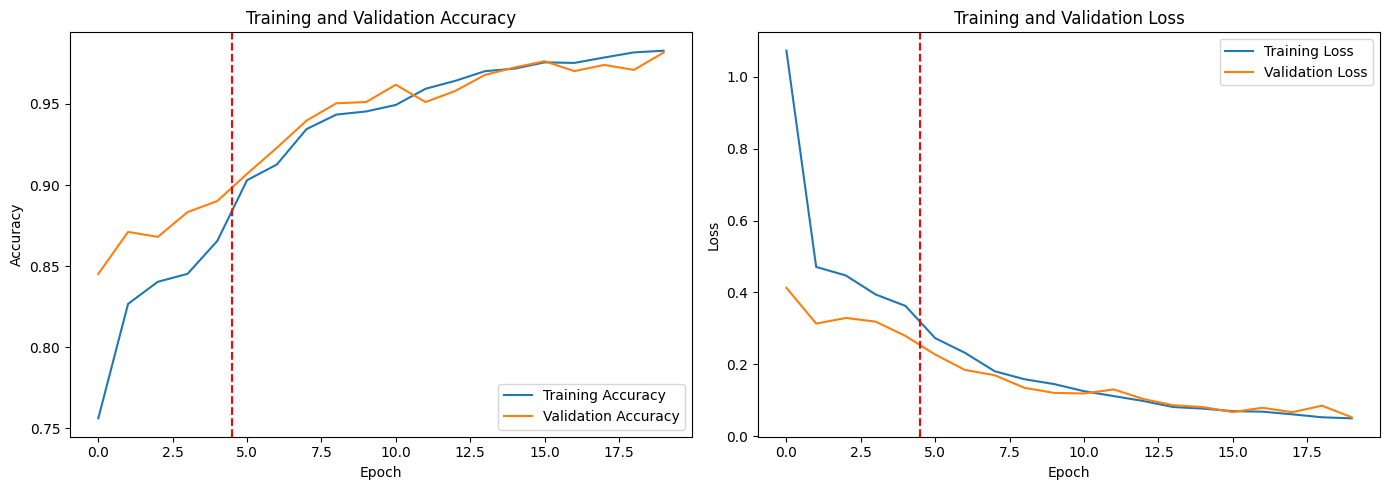

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os

REPORTS_DIR = '../reports'
PLOT_FILE = os.path.join(REPORTS_DIR, 'training_history.png')

if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)

history_combined = {}

try:
    for key in history_1.history.keys():
        history_combined[key] = history_1.history[key] + history_2.history[key]

    epochs_range = range(len(history_combined['accuracy']))
    fine_tune_start_epoch = len(history_1.history['accuracy'])

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_combined['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history_combined['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.axvline(x=fine_tune_start_epoch - 0.5, color='r', linestyle='--', label='Fine-Tuning Start')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_combined['loss'], label='Training Loss')
    plt.plot(epochs_range, history_combined['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.axvline(x=fine_tune_start_epoch - 0.5, color='r', linestyle='--', label='Fine-Tuning Start')

    plt.tight_layout()
    plt.savefig(PLOT_FILE)

    print(f"\n Visualization completed and saved to: {PLOT_FILE}")

except NameError:
    print(" ERROR: Visualization failed. Please ensure that you have run the Stage 1 (history_1) and Stage 2 (history_2) training code blocks in the correct order.")
except Exception as e:
    print(f" An unexpected error occurred during visualization: {e}")


*** Reliably Calculating Model Performance ***


100%|██████████| 41/41 [00:01<00:00, 28.67it/s]



Test Loss (Loss - Manual): 0.0531
Test Accuracy (Overall): 98.17%

*** Classification Report ***
Class         Precision   Recall   F1-Score    Support
----------------------------------------------------
glioma             0.99     0.96       0.97        300
meningioma         0.96     0.97       0.96        306
notumor            1.00     1.00       1.00        405
pituitary          0.97     0.99       0.98        300

Confusion Matrix calculated and saved to: ../reports\confusion_matrix_consistent.png


<Figure size 800x800 with 0 Axes>

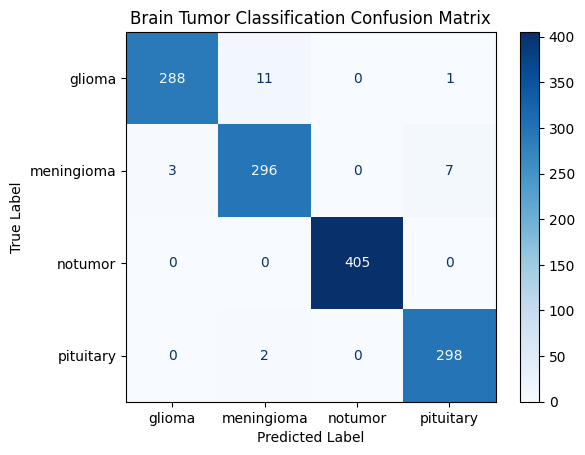

In [ ]:
from tqdm import tqdm 
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print("\n*** Reliably Calculating Model Performance ***")

test_generator.reset()

num_test_samples = test_generator.samples
TOTAL_STEPS = int(math.ceil(num_test_samples / BATCH_SIZE)) 

X_test, y_test_true = [], []
class_labels = list(test_generator.class_indices.keys())

for i in tqdm(range(TOTAL_STEPS)):
    try:
        x, y = next(test_generator)
        X_test.append(x)
        y_test_true.append(y)
    except StopIteration:
        break 

X_test = np.concatenate(X_test, axis=0)
y_test_true = np.concatenate(y_test_true, axis=0)

y_true_classes = np.argmax(y_test_true, axis=1)

y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)



loss, acc = model.evaluate(X_test, y_test_true, verbose=0)

precision, recall, f1_score, support = precision_recall_fscore_support(
    y_true_classes, 
    y_pred_classes, 
    average=None, 
    zero_division=0
)

print(f"\nTest Loss (Loss - Manual): {loss:.4f}")
print(f"Test Accuracy (Overall): {acc*100:.2f}%")

print("\n*** Classification Report ***")
print(f"{'Class':<12} {'Precision':>10} {'Recall':>8} {'F1-Score':>10} {'Support':>10}")
print("-" * 52)
for i, label in enumerate(class_labels):
    print(f"{label:<12} {precision[i]:>10.2f} {recall[i]:>8.2f} {f1_score[i]:>10.2f} {support[i]:>10}")


cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.title('Brain Tumor Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

CM_FILE = os.path.join('../reports', 'confusion_matrix_consistent.png')
plt.savefig(CM_FILE)

print(f"\nConfusion Matrix calculated and saved to: {CM_FILE}")

In [17]:
import os
from tensorflow.keras.models import load_model
from keras.layers import TFSMLayer 
import tensorflow as tf

MODEL_ROOT_DIR = "../models"
MODEL_NAME = "brain_tumor_resnet_v1_savedmodel"
SAVED_MODEL_DIR = os.path.join(MODEL_ROOT_DIR, MODEL_NAME)

if os.path.exists(SAVED_MODEL_DIR):
    try:
        model = TFSMLayer(SAVED_MODEL_DIR, call_endpoint='serve')
        print(f"Model successfully loaded as TFSMLayer for inference: {SAVED_MODEL_DIR}")
        is_model_loaded = True
    except Exception as e:
        print(f"ERROR: Failed to load saved model. Detail: {e}")
        is_model_loaded = False
else:
    print(f"Model not found on disk: {SAVED_MODEL_DIR}")
    is_model_loaded = False

if not is_model_loaded:
    try:
        os.makedirs(SAVED_MODEL_DIR, exist_ok=True)
        model.export(SAVED_MODEL_DIR) 
        print(f"Model successfully saved in SavedModel format: {SAVED_MODEL_DIR}")
    except NameError:
        print(f"ERROR: 'model' object is not defined in memory. Saving failed. Please re-run the training cells.")
    except Exception as e:
        print(f"ERROR: An unexpected error occurred during saving (Export failed). Detail: {e}")

Model successfully loaded as TFSMLayer for inference: ../models\brain_tumor_resnet_v1_savedmodel
